In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


1. Load the Dataset

In [2]:
# Load the dataset
file_path = 'Job_ML_Filtered.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Display dataset structure
print(data.head())
print(data.info())


   Job Role     Experience Qualifications Salary Range    location  \
0         1  5 to 15 Years         M.Tech    $59K-$99K     Douglas   
1         2  2 to 12 Years            BCA   $56K-$116K    Ashgabat   
2         3  0 to 12 Years            PhD   $61K-$104K       Macao   
3         4  4 to 11 Years            PhD    $65K-$91K  Porto-Novo   
4         5  1 to 12 Years            MBA    $64K-$87K    Santiago   

            Country  Work Type  Company Size Job Posting Date Preference  ...  \
0       Isle of Man     Intern         26801       2022-04-24     Female  ...   
1      Turkmenistan     Intern        100340       2022-12-19     Female  ...   
2  Macao SAR, China  Temporary         84525       2022-09-14       Male  ...   
3             Benin  Full-Time        129896       2023-02-25     Female  ...   
4             Chile     Intern         53944       2022-10-11     Female  ...   

                 Contact                     Job Title  \
0   001-381-930-7517x737  Digital 

In [3]:
data.columns

Index(['Job Role', 'Experience', 'Qualifications', 'Salary Range', 'location',
       'Country', 'Work Type', 'Company Size', 'Job Posting Date',
       'Preference', 'Contact Person', 'Contact', 'Job Title', 'Role',
       'Job Portal', 'Job Description', 'Benefits', 'skills',
       'Responsibilities', 'Company', 'Company Profile'],
      dtype='object')

2. Data Preprocessing

Handle Missing Values

In [4]:
import pandas as pd

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows/columns (based on context)
data.fillna(method='ffill', inplace=True)  # Example: Forward fill

# Replace with the mode (most frequent value)
data['Company Profile'].fillna(data['Company Profile'].mode()[0], inplace=True)



Job Role            0
Experience          0
Qualifications      0
Salary Range        0
location            0
Country             0
Work Type           0
Company Size        0
Job Posting Date    0
Preference          0
Contact Person      0
Contact             0
Job Title           0
Role                0
Job Portal          0
Job Description     0
Benefits            0
skills              0
Responsibilities    0
Company             0
Company Profile     2
dtype: int64


C:\Users\cheta\AppData\Local\Temp\ipykernel_6316\3919559120.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Example: Forward fill
C:\Users\cheta\AppData\Local\Temp\ipykernel_6316\3919559120.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Company Profile'].fillna(data['Company Profile'].mode()[0], inplace=True)


Encode Categorical Features

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Example for label encoding
le = LabelEncoder()
data['Experience'] = le.fit_transform(data['Experience'])

# Example for label encoding
le1 = LabelEncoder()
data['Qualifications'] = le.fit_transform(data['Qualifications'])

# Example for label encoding
le2 = LabelEncoder()
data['location'] = le.fit_transform(data['location'])

# Example for label encoding
le3 = LabelEncoder()
data['Job Posting Date'] = le.fit_transform(data['Job Posting Date'])

# Example for label encoding
le4 = LabelEncoder()
data['Contact Person'] = le.fit_transform(data['Contact Person'])

# Example for label encoding
le5 = LabelEncoder()
data['Contact'] = le.fit_transform(data['Contact'])

# Example for label encoding
le5 = LabelEncoder()
data['Role'] = le.fit_transform(data['Role'])

# Example for label encoding
le6 = LabelEncoder()
data['Job Title'] = le.fit_transform(data['Job Title'])

# Example for label encoding
le7 = LabelEncoder()
data['Responsibilities'] = le.fit_transform(data['Responsibilities'])

# Example for label encoding
le8 = LabelEncoder()
data['Job Description'] = le.fit_transform(data['Job Description'])

# Example for label encoding
le9 = LabelEncoder()
data['Benefits'] = le.fit_transform(data['Benefits'])

# Example for label encoding
le10 = LabelEncoder()
data['skills'] = le.fit_transform(data['skills'])

# Example for label encoding
le11 = LabelEncoder()
data['Company Profile'] = le.fit_transform(data['Company Profile'])

# Example for label encoding
le12 = LabelEncoder()
data['Company'] = le.fit_transform(data['Company'])

# Example for label encoding
le13 = LabelEncoder()
data['Preference'] = le.fit_transform(data['Preference'])

# Example for one-hot encoding
data = pd.get_dummies(data, columns=['Job Portal', 'Country', 'Work Type'], drop_first=True)


Feature Engineering

In [6]:
# Remove 'K' and '$' symbols
data['Salary Range'] = data['Salary Range'].str.replace('K', '').str.replace('$', '', regex=False)

# Split into Min_Salary and Max_Salary
data[['Min_Salary', 'Max_Salary']] = (
    data['Salary Range']
    .str.split('-', expand=True)
    .apply(pd.to_numeric, errors='coerce')
)

# Calculate the average salary
data['Salary'] = (data['Min_Salary'] + data['Max_Salary']) / 2

# Drop unnecessary columns
data.drop(['Salary Range', 'Min_Salary', 'Max_Salary'], axis=1, inplace=True)



3. Split Data into Features and Target

In [7]:
# Assume "Preference" is the target variable
X = data.drop(['Preference'], axis=1)  # Features
y = data['Preference']  # Target


In [8]:
from sklearn.feature_selection import SelectKBest, chi2

# Feature selection
selector = SelectKBest(score_func=chi2, k=15)
X_new = selector.fit_transform(X, y)

# Get the names of the selected features
selected_features = X.columns[selector.get_support()]

In [9]:
selected_features

Index(['Job Role', 'Qualifications', 'location', 'Company Size',
       'Job Posting Date', 'Contact Person', 'Contact', 'Job Title', 'Role',
       'Job Description', 'skills', 'Responsibilities', 'Company',
       'Company Profile', 'Country_India'],
      dtype='object')

In [10]:
X_selected = X[selected_features]

4. Split Dataset into Training and Testing Sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5. Model Selection

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

6. Model Evaluation

In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.315
              precision    recall  f1-score   support

           0       0.31      0.30      0.31        73
           1       0.50      0.30      0.37        71
           2       0.23      0.36      0.28        56

    accuracy                           0.32       200
   macro avg       0.35      0.32      0.32       200
weighted avg       0.35      0.32      0.32       200



7. Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


8. Feature Importance

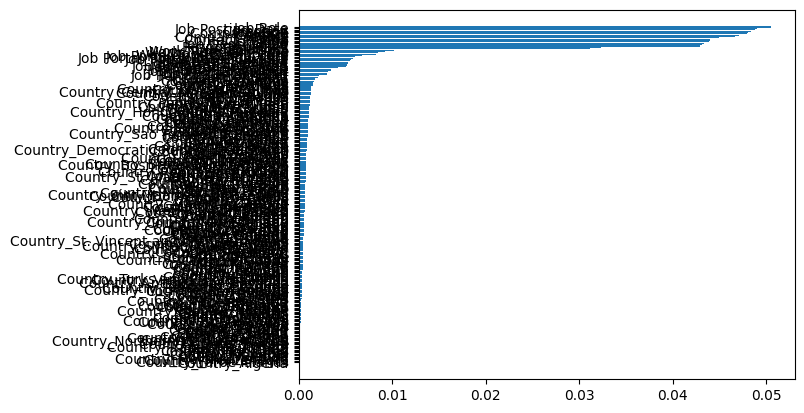

In [15]:
importances = model.feature_importances_
features = X.columns
sorted_indices = importances.argsort()

# Plot feature importance
import matplotlib.pyplot as plt

plt.barh(features[sorted_indices], importances[sorted_indices])
plt.show()


9. Address Class Imbalance

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


10. Validation

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Accuracy: {scores.mean()}")


Cross-Validation Accuracy: 0.31732160804020104


11.  Deployment

In [18]:
import joblib

joblib.dump(best_model, 'final_model.pkl')


['final_model.pkl']